# AOD Data Analysis using Python


<h3>Scattering Angle</h3>

- Scattering angle is the angle at which a light beam is deflected by a particle when it comes in contact with it.

<h3>Cloud Fraction</h3>

- Cloud fraction is the percentage of each pixel in satellite imagery or each gridbox in a weather or climate model that is covered with clouds. A cloud fraction of one means the pixel is completely covered with clouds, while a cloud fraction of zero represents a totally cloud free pixel. Cloud fraction is important for the modeling of downward radiation

<h3>Angstrom exponent</h3>

- The Angstrom exponent or Angstrom exponent is a parameter that describes how the optical thickness of an aerosol typically depends on the wavelength of the light.

<h3>Deep Blue AOD</h3>

- Deep Blue is an algorithm used to calculate aerosol optical depth (AOD) and Ångström Exponent (α or AE) over land using data from the aforementioned satellite instruments. By making use of measurements at different wavelengths, with different contrast between surface and atmospheric features, Deep Blue estimates AOD. This process is known as a 'retrieval'. At many wavelengths of visible light, the contrast between aerosols and the surface is difficult to discern, but in the 412 nm band, aerosol signals tend to be bright and surface features dark. The 412 nm band is sometimes referred to as the "deep blue" band, from which the algorithm gets its name. AOD retrieval in the 412 nm band allows for increased spatial coverage relative to tthe Dark Target algorithm, which makes different assumptions which are not valid over bright surfaces such as deserts.


In [0]:
import gdal
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
import os
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#os.listdir('drive/My Drive/Colab Notebooks/November')

In [0]:
#os.listdir('drive/My Drive/Colab Notebooks')

In [0]:
#Lists all subdatasets of any one file
f = []
file = gdal.Open('drive/My Drive/MCD19A2.A2019305.h24v06.006.2019307040747.hdf')#Colab Notebooks/November/2018.11.18.hdf')
for path, desc in file.GetSubDatasets():
    #print(desc)
    f.append(desc)

In [5]:
len(f)

13

In [0]:
# Opens the HDF file
def load_data(FILEPATH):
    ds = gdal.Open(FILEPATH)
    return ds

In [0]:
# Opens the data HDF file and returns as a dataframe
def read_dataset(SUBDATASET_NAME, FILEPATH):
    dataset = load_data(FILEPATH)
    path = ''
    for sub, description in dataset.GetSubDatasets():
        if (description.endswith(SUBDATASET_NAME)):
            path = sub
            break
    if(path == ''):
        print(SUBDATASET_NAME + ' not found')
        return
    subdataset = gdal.Open(path)
    subdataset = subdataset.ReadAsArray()
    subdataset = pd.DataFrame(subdataset)
    return subdataset

In [0]:
# Loads the HDF file, gets the Latitude subdataset and returns the information of the nearest pixel to specified position
def find_latitude_position(CITY_LATITUDE, FILEPATH):
    dataset_to_load = 'Latitude (32-bit floating-point)'
    latitude_dataframe = read_dataset(dataset_to_load, FILEPATH)
    min_diff = 100
    row_number = -1
    column_number = -1
    rows = latitude_dataframe.shape[0]
    columns = latitude_dataframe.shape[1]
    for i in range(rows):
        for j in range(columns):
            lat = latitude_dataframe.iloc[i][j]
            diff = np.abs(lat - CITY_LATITUDE)
            if(diff < min_diff):
                min_diff = diff
                row_number = i
                column_number = j
                found_lat = lat
    if(row_number == -1 or column_number == -1):
        print("Latitude not found. You might have chosen wrong scene")
    return latitude_dataframe, row_number, column_number
    

In [0]:
# Loads the HDF file, gets the Longitude subdataset and returns the information of the nearest pixel to specified position
def find_longitude_position(CITY_LONGITUDE, LATITUDE_ROW_NUMBER, FILEPATH):
    dataset_to_load = 'Longitude (32-bit floating-point)'
    longitude_dataframe = read_dataset(dataset_to_load, FILEPATH)
    min_diff = 100
    row_number = -1
    column_number = -1
    rows = longitude_dataframe.shape[0]
    columns = longitude_dataframe.shape[1]
    for j in range(columns):
        lon = longitude_dataframe.iloc[LATITUDE_ROW_NUMBER][j]
        diff = np.abs(lon - CITY_LONGITUDE)
        if(diff < min_diff):
            min_diff = diff
            row_number = LATITUDE_ROW_NUMBER
            column_number = j
            found_lon = lon
    if(column_number == -1):
        print("Longitude not found. You might have chosen wrong scene")
    return longitude_dataframe, column_number
    

In [0]:
def find_product_value(LATITUDE_ROW_NUMBER, LONGITUDE_COLUMN_NUMBER, SUBDATASET, FILEPATH):
    dataset = read_dataset(SUBDATASET, FILEPATH)
    if(LATITUDE_ROW_NUMBER < 0 or LONGITUDE_COLUMN_NUMBER < 0):
        return -1
    return dataset.iloc[LATITUDE_ROW_NUMBER][LONGITUDE_COLUMN_NUMBER]

In [0]:
# Creates a list of values of the product under observation across all datasets
def create_list(PRODUCT, CITY_LATITUDE, CITY_LONGITUDE, FILEPATH):
    latitude_dataframe, lat_row, lat_column = find_latitude_position(CITY_LATITUDE, FILEPATH)
    if lat_row == -1:
        return -1
    longitude_dataframe, lon_column = find_longitude_position(CITY_LONGITUDE, lat_row, FILEPATH)
    city_row_number = lat_row
    city_column_number = lon_column
    if(PRODUCT == 'AOD'):
        subdataset = 'Deep_Blue_Aerosol_Optical_Depth_550_Land mod04 (16-bit integer)'
    elif(PRODUCT == 'Scattering Angle'):
        subdataset = 'Scattering_Angle mod04 (16-bit integer)'
    elif(PRODUCT == 'Cloud Fraction'):
        subdataset = 'Deep_Blue_Cloud_Fraction_Land (16-bit integer)'
    elif(PRODUCT == 'Combined'):
        subdataset = 'AOD_550_Dark_Target_Deep_Blue_Combined (16-bit integer)'
    elif(PRODUCT == 'Angstrom Exponent'):
        subdataset = 'Deep_Blue_Angstrom_Exponent_Land (16-bit integer)'
    row_begin = city_row_number - 1
    row_end = city_row_number + 1
    column_begin = city_column_number - 1
    column_end = city_column_number + 1
    total = 0
    for i in range(row_begin, row_end, 1):
        for j in range(column_begin, column_end, 1):
            pixel_value = find_product_value(i, j, subdataset, FILEPATH)
            if(pixel_value == -9999):
                pixel_value = 0
            total = total + pixel_value
    product_value = total / 9
    return product_value, latitude_dataframe.iloc[lat_row][lat_column], longitude_dataframe.iloc[lat_row][lon_column]


In [0]:
# Defining lists to store all the calculated values
scattering_angle = []
deep_blue_AOD_Land = []
cloud_fraction = []
file_names = []
latitude = []
longitude = []
combined_AOD = []
angstrom_exponent = []
directory = 'drive/My Drive/Colab Notebooks/November'

In [18]:
import glob
for file in glob.glob(directory + '/*.hdf'):
    FILEPATH = file
    print(FILEPATH)
    scattering_angle_value, lat, lon = create_list('Scattering Angle', 26.8467, 80.9462, FILEPATH)
    deep_blue_AOD_Land_value, lat, lon = create_list('AOD', 26.8467, 80.9462, FILEPATH)
    cloud_fraction_value, lat, lon = create_list('Cloud Fraction', 26.8467, 80.9462, FILEPATH)
    combined_AOD_value, lat, lon = create_list('Combined', 26.8467, 80.9462, FILEPATH)
    angstrom_exponent_value, lat, lon = create_list('Angstrom Exponent', 26.8467, 80.9462, FILEPATH)
    file_names.append(file)
    scattering_angle.append(scattering_angle_value)
    deep_blue_AOD_Land.append(deep_blue_AOD_Land_value)
    latitude.append(lat)
    longitude.append(lon)
    cloud_fraction.append(cloud_fraction_value)
    combined_AOD.append(combined_AOD_value)
    angstrom_exponent.append(angstrom_exponent_value)

drive/My Drive/Colab Notebooks/November/2018.11.1.hdf
drive/My Drive/Colab Notebooks/November/2018.11.10.hdf
drive/My Drive/Colab Notebooks/November/2018.11.11.hdf
drive/My Drive/Colab Notebooks/November/2018.11.12.hdf
drive/My Drive/Colab Notebooks/November/2018.11.13(Part 2).hdf
drive/My Drive/Colab Notebooks/November/2018.11.13.hdf
drive/My Drive/Colab Notebooks/November/2018.11.14.hdf
drive/My Drive/Colab Notebooks/November/2018.11.15.hdf
drive/My Drive/Colab Notebooks/November/2018.11.16.hdf
drive/My Drive/Colab Notebooks/November/2018.11.17(Part 2).hdf
drive/My Drive/Colab Notebooks/November/2018.11.17.hdf
drive/My Drive/Colab Notebooks/November/2018.11.18.hdf
drive/My Drive/Colab Notebooks/November/2018.11.19.hdf
drive/My Drive/Colab Notebooks/November/2018.11.2.hdf
drive/My Drive/Colab Notebooks/November/2018.11.20.hdf
drive/My Drive/Colab Notebooks/November/2018.11.21(Part 2).hdf
drive/My Drive/Colab Notebooks/November/2018.11.21.hdf
drive/My Drive/Colab Notebooks/November/201

In [0]:
final_list = pd.DataFrame()
final_list['File Name'] = pd.Series(file_names)
final_list['Scattering_angle'] = pd.Series(scattering_angle)
final_list['Deep Blue AOD'] = pd.Series(deep_blue_AOD_Land)
final_list['Cloud Fraction'] = pd.Series(cloud_fraction)
final_list['Combined AOD'] = pd.Series(combined_AOD)
final_list['Angstrom Exponent'] = pd.Series(angstrom_exponent)
final_list['Latitude'] = pd.Series(latitude)
final_list['Longitude'] = pd.Series(longitude)

In [0]:
path = 'drive/My Drive/Colab Notebooks/2018_Nov.csv'
final_list.to_csv(path)

In [0]:
d = pd.read_csv('drive/My Drive/Colab Notebooks/November/2018_Nov.csv')

In [29]:
d.columns

Index(['Unnamed: 0', 'File Name', 'Scattering_angle', 'Deep Blue AOD',
       'Cloud Fraction', 'Combined AOD', 'Angstrom Exponent', 'Latitude',
       'Longitude'],
      dtype='object')

In [30]:
d.head()

,Unnamed: 0,File Name,Scattering_angle,Deep Blue AOD,Cloud Fraction,Combined AOD,Angstrom Exponent,Latitude,Longitude
0,0,drive/My Drive/Colab Notebooks/November/2018.1...,6070.888889,30.555556,42.222222,70.888889,666.666667,26.846889,80.962296
1,1,drive/My Drive/Colab Notebooks/November/2018.1...,3042.000000,142.666667,-0.222222,124.444444,108.444444,26.846695,80.879623
2,2,drive/My Drive/Colab Notebooks/November/2018.1...,4531.222222,393.444444,60.000000,629.777778,800.000000,26.846355,80.895363
3,3,drive/My Drive/Colab Notebooks/November/2018.1...,6215.333333,457.555556,0.000000,426.666667,517.333333,26.846518,80.951187
4,4,drive/My Drive/Colab Notebooks/November/2018.1...,4333.000000,101.888889,4.444444,170.888889,610.666667,26.846645,80.375854


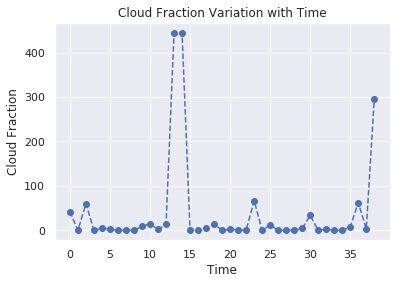

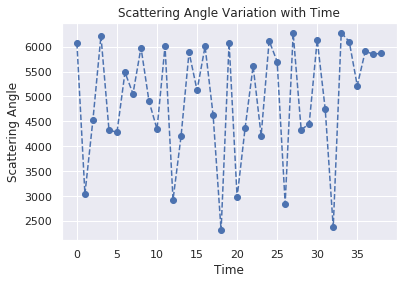

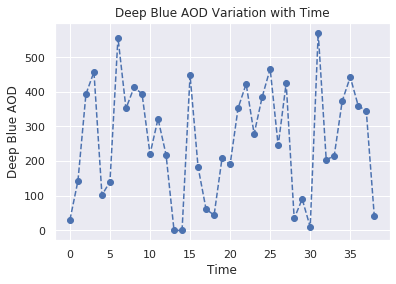

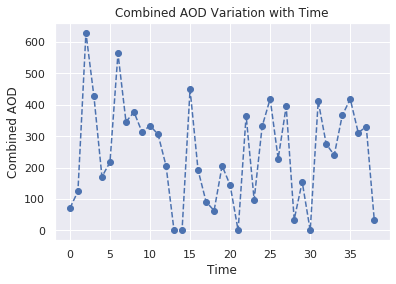

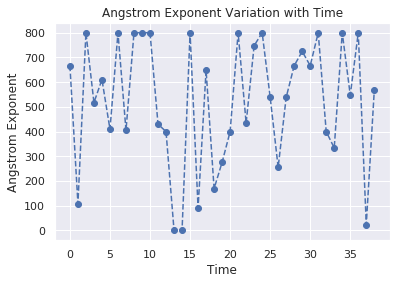

In [42]:
import matplotlib.pyplot as plt

plt.plot(d['Cloud Fraction'],'o--')
plt.xlabel("Time")
plt.ylabel("Cloud Fraction")
plt.title("Cloud Fraction Variation with Time")
plt.show()

plt.plot(d['Scattering_angle'],'o--')
plt.xlabel("Time")
plt.ylabel("Scattering Angle")
plt.title("Scattering Angle Variation with Time")
plt.show()


plt.plot(d['Deep Blue AOD'],'o--')
plt.xlabel("Time")
plt.ylabel("Deep Blue AOD")
plt.title("Deep Blue AOD Variation with Time")
plt.show()

plt.plot(d['Combined AOD'],'o--')
plt.xlabel("Time")
plt.ylabel("Combined AOD")
plt.title("Combined AOD Variation with Time")
plt.show()

plt.plot(d['Angstrom Exponent'],'o--')
plt.xlabel("Time")
plt.ylabel("Angstrom Exponent")
plt.title("Angstrom Exponent Variation with Time")
plt.show()